# Musk - NonMusk Compound Detection
#### By Raghav Gurung

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
import talos

1.15.0


Using TensorFlow backend.


In [7]:
df = pd.read_csv('drive/My Drive/Datasets/musk_csv.csv')
df.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


In [0]:
# Seperation features and label
X = np.array(df.iloc[:, 3:-1].values, dtype=np.float32)
Y = np.array(df.iloc[:, -1], dtype=np.float32)

In [9]:
from sklearn.preprocessing import StandardScaler

# Here we standardize the features with mean = 0 and std = 1
X = StandardScaler().fit_transform(X)

print(np.mean(X))
print(np.std(X))

-9.473459e-10
0.99999994


In [10]:
from sklearn.model_selection import train_test_split

# Splitting data and keeping 40% of data for holdout and later evaluation
X_, X_holdout, Y_, Y_holdout = train_test_split(X, Y, test_size=0.4, random_state=333, stratify=Y)

# Now splitting X_ and Y_ for training and test
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=333, stratify=Y_)

print(X_train.shape)
print(X_test.shape)

(3166, 166)
(792, 166)


# Automatic HyperParameter Tuning
Here I use the talos library with keras for hyperparameter optimization.
We use a combination of around 600 parameters and train the features.
We then later analyse the best parameters to use for training the features with.

In [0]:
from keras.models import Sequential
from keras.activations import relu, elu, sigmoid
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh


# first we have to make sure to input data and params into the function
def musk_compound_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation=params['activation']))
    
    model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['acc', talos.utils.metrics.f1score])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model


In [0]:
# set the parameter space
p = {'lr': [0.003, 0.03, 1],
     'first_neuron':[64, 128, 256],
     'hidden_layers':[0, 1, 2],
     'batch_size': [20, 30, 50],
     'epochs': [20, 30, 50],
     'dropout': [0, 0.2, 0.5],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'shape':['brick','long_funnel'],
     'optimizer': ['adam','nadam', 'rmsprop'],
     'losses': [logcosh, binary_crossentropy],
     'activation':[relu, elu],
     'last_activation': [sigmoid]}

In [0]:
# run the experiment
t = talos.Scan(x=X_train,
               y=y_train,
               x_val=X_test,
               y_val=y_test,
               model=musk_compound_model,
               params=p,
               fraction_limit=0.1,
               random_method='quantum',
               experiment_name="musk_1")

In [41]:
# Deploying the models
talos.Deploy(t, 'musk_exp_2', metric='f1score')

Deploy package musk_exp_2 have been saved.


In [71]:
e = talos.Evaluate(t)
e

In [87]:
e.evaluate(X_holdout, Y_holdout, task='binary', metric='val_f1score', print_out=True)

mean : 0.97 
 std : 0.01


[0.978494623655914,
 0.971830985915493,
 0.9589041095890412,
 0.9738219895287958,
 0.943661971830986]

In [82]:
talos.Deploy(t, 'musk_exp_3', metric='val_f1score')

Deploy package musk_exp_3 have been saved.


## We now have all the parameters in a nice dataframe for us to analyze.

In [89]:
val_f1score = talos.Reporting('musk_exp_3_results.csv')
round1_res_df = val_f1score.data.sort_values('val_f1score', ascending=False).iloc[:, 1:]
round1_res_df.head()

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,emb_output_dims,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer,shape,weight_regulizer
554,50,0.032065,0.991162,0.941298,0.000475,0.999684,0.984558,<function relu at 0x7fbe74c5e950>,26,0.0,NaN,50,128,0,<function sigmoid at 0x7fbe74c5ea60>,<function binary_crossentropy at 0x7fbe74ca46a8>,0.003,rmsprop,brick,NaN
25,50,0.002998,0.991162,0.938987,0.000082,0.999684,0.998386,<function relu at 0x7fbe74c5e950>,28,0.0,NaN,50,128,2,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,rmsprop,long_funnel,NaN
467,50,0.059131,0.989899,0.938772,0.000033,1.000000,0.983575,<function relu at 0x7fbe74c5e950>,26,0.0,NaN,50,256,1,<function sigmoid at 0x7fbe74c5ea60>,<function binary_crossentropy at 0x7fbe74ca46a8>,0.003,rmsprop,long_funnel,NaN
469,50,0.003441,0.991162,0.938714,0.000278,0.999368,0.994663,<function relu at 0x7fbe74c5e950>,29,0.0,NaN,50,256,0,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,nadam,brick,NaN
91,30,0.003680,0.991162,0.938273,0.000038,1.000000,1.000000,<function relu at 0x7fbe74c5e950>,28,0.0,NaN,30,128,1,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,nadam,long_funnel,NaN


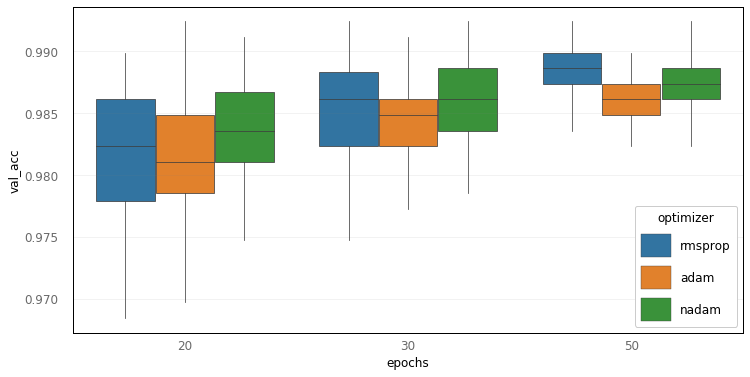

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

sns.boxplot('epochs', 'val_acc', 
            data=round1_res_df, 
            hue='optimizer')

We can see that 50 epochs with 'nadam' optimizer is better for accuracy.
We will use this later for training.

In [99]:
# We create a column which shows the accuracy and f1scores with less overfitting.
round1_res_df['acc_entropy'] = round1_res_df['acc'] - round1_res_df['val_acc']
round1_res_df['acc_entropy'].describe()

count    648.000000
mean       0.012961
std        0.004091
min       -0.003169
25%        0.010416
50%        0.012626
75%        0.015152
max        0.045451
Name: acc_entropy, dtype: float64

In [101]:
round1_res_df['f1score_entropy'] = round1_res_df['f1score'] - round1_res_df['val_f1score']
round1_res_df['f1score_entropy'].describe()

count    648.000000
mean       0.069877
std        0.022305
min        0.000739
25%        0.056797
50%        0.067773
75%        0.081745
max        0.204326
Name: f1score_entropy, dtype: float64

In [104]:
round1_res_df = round1_res_df[round1_res_df['acc_entropy'] >= 0]
round1_res_df = round1_res_df.sort_values(['acc_entropy', 'f1score_entropy'])
round1_res_df.head()

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,emb_output_dims,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer,shape,weight_regulizer,acc_entropy,f1score_entropy
252,20,0.006454,0.982323,0.890383,0.005211,0.987050,0.891122,<function elu at 0x7fbe74c5e730>,20,0.0,NaN,20,64,2,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,rmsprop,long_funnel,NaN,0.004727,0.000739
361,20,0.006721,0.981061,0.888878,0.004048,0.988313,0.897048,<function elu at 0x7fbe74c5e730>,20,0.0,NaN,20,256,1,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,adam,long_funnel,NaN,0.007253,0.008170
568,50,0.026368,0.988636,0.913861,0.000167,1.000000,0.922299,<function relu at 0x7fbe74c5e950>,20,0.0,NaN,50,256,1,<function sigmoid at 0x7fbe74c5ea60>,<function binary_crossentropy at 0x7fbe74ca46a8>,0.003,adam,brick,NaN,0.011364,0.008439
380,20,0.036887,0.986111,0.902038,0.025692,0.990208,0.912775,<function elu at 0x7fbe74c5e730>,20,0.0,NaN,20,128,1,<function sigmoid at 0x7fbe74c5ea60>,<function binary_crossentropy at 0x7fbe74ca46a8>,0.003,rmsprop,brick,NaN,0.004097,0.010737
327,20,0.007798,0.979798,0.906074,0.005742,0.985786,0.922664,<function elu at 0x7fbe74c5e730>,26,0.0,NaN,20,64,2,<function sigmoid at 0x7fbe74c5ea60>,<function logcosh at 0x7fbe74ca4510>,0.003,rmsprop,brick,NaN,0.005989,0.016590


In [0]:
# Cleaning some columns
round1_res_df['activation'] = round1_res_df['activation'].apply(lambda x: x.split()[1])

In [0]:
round1_res_df['last_activation'] = round1_res_df['last_activation'].apply(lambda x: x.split()[1])
round1_res_df['losses'] = round1_res_df['losses'].apply(lambda x: x.split()[1])

In [111]:
round1_res_df.head(10)

,round_epochs,val_loss,val_acc,val_f1score,loss,acc,f1score,activation,batch_size,dropout,emb_output_dims,epochs,first_neuron,hidden_layers,last_activation,losses,lr,optimizer,shape,weight_regulizer,acc_entropy,f1score_entropy
252,20,0.006454,0.982323,0.890383,0.005211,0.987050,0.891122,elu,20,0.0,NaN,20,64,2,sigmoid,logcosh,0.003,rmsprop,long_funnel,NaN,0.004727,0.000739
361,20,0.006721,0.981061,0.888878,0.004048,0.988313,0.897048,elu,20,0.0,NaN,20,256,1,sigmoid,logcosh,0.003,adam,long_funnel,NaN,0.007253,0.008170
568,50,0.026368,0.988636,0.913861,0.000167,1.000000,0.922299,relu,20,0.0,NaN,50,256,1,sigmoid,binary_crossentropy,0.003,adam,brick,NaN,0.011364,0.008439
380,20,0.036887,0.986111,0.902038,0.025692,0.990208,0.912775,elu,20,0.0,NaN,20,128,1,sigmoid,binary_crossentropy,0.003,rmsprop,brick,NaN,0.004097,0.010737
327,20,0.007798,0.979798,0.906074,0.005742,0.985786,0.922664,elu,26,0.0,NaN,20,64,2,sigmoid,logcosh,0.003,rmsprop,brick,NaN,0.005989,0.016590
306,30,0.005197,0.984848,0.897518,0.002723,0.993367,0.916745,elu,21,0.0,NaN,30,256,2,sigmoid,logcosh,0.003,adam,long_funnel,NaN,0.008519,0.019227
428,20,0.006019,0.986111,0.899874,0.004180,0.987682,0.921020,elu,21,0.0,NaN,20,128,2,sigmoid,logcosh,0.003,adam,long_funnel,NaN,0.001571,0.021146
94,20,0.040603,0.981061,0.910792,0.031284,0.989261,0.934415,elu,26,0.0,NaN,20,64,2,sigmoid,binary_crossentropy,0.003,rmsprop,long_funnel,NaN,0.008200,0.023623
526,20,0.043416,0.983586,0.916404,0.027391,0.989577,0.940161,elu,26,0.0,NaN,20,128,0,sigmoid,binary_crossentropy,0.003,rmsprop,brick,NaN,0.005991,0.023758
509,20,0.007969,0.979798,0.883255,0.004472,0.989261,0.907249,elu,20,0.0,NaN,20,256,0,sigmoid,logcosh,0.003,rmsprop,brick,NaN,0.009463,0.023993


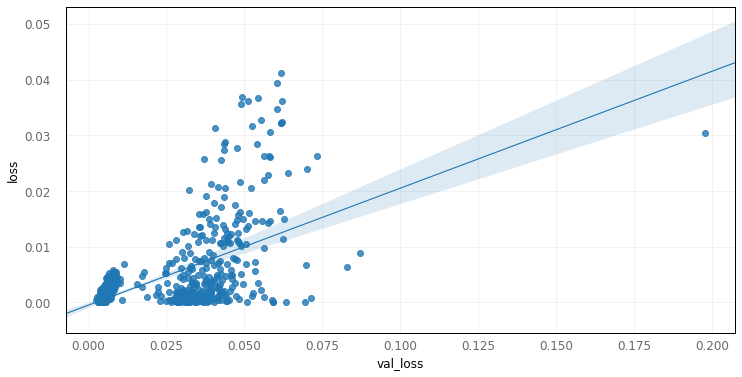

In [113]:
plt.figure(figsize=(12,6))
sns.regplot('val_loss', 'loss', data=round1_res_df)
plt.show()

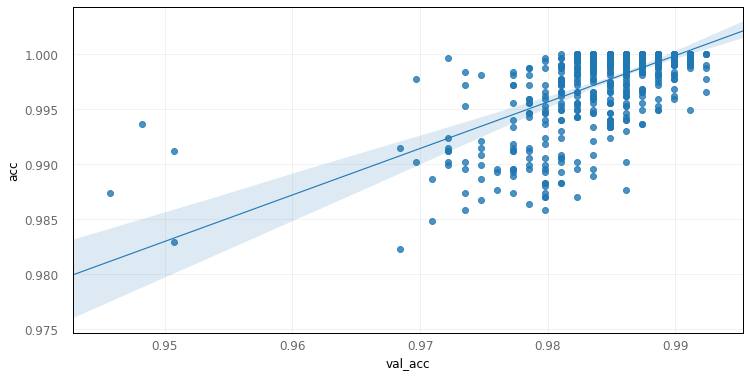

In [114]:
plt.figure(figsize=(12,6))
sns.regplot('val_acc', 'acc', data=round1_res_df)
plt.show()

## We will now train the data again with the best paramaters that we have found.

In [0]:
fX_train, fX_test, fy_train, fy_test = train_test_split(X, Y, test_size=0.2, random_state=333, stratify=Y)


In [173]:
from keras.optimizers import RMSprop, Nadam

final_model = Sequential()
final_model.add(Dense(256, activation='relu', input_dim=166))
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(0.2))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dense(1, activation='sigmoid'))

final_model.summary()

final_model.compile(loss='binary_crossentropy',
                    optimizer=Nadam(lr=0.003),
                    metrics=['accuracy'])

f_history = final_model.fit(X_train, y_train,
                            validation_data=[X_test, y_test],
                            epochs=100)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               42752     
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 83,969
Trainable params: 83,969
Non-trainable params: 0
_________________________________________________________________
Train on 3166 samples, validate on 792 samples
Epoch 1/100
3166/3166 [==============================] - 2s 566us/st

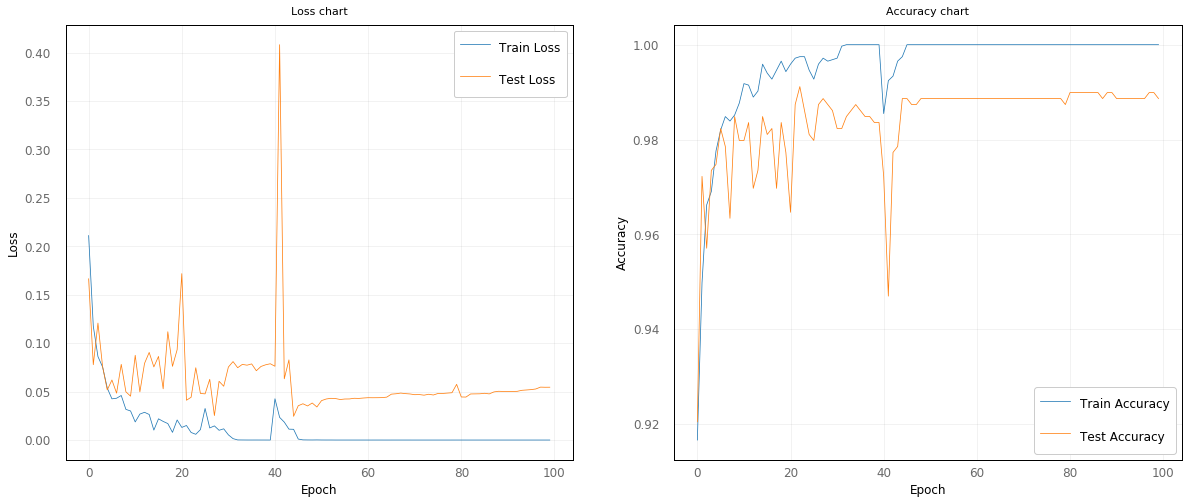

In [174]:
loss = f_history.history['loss']
val_loss = f_history.history['val_loss']

acc = f_history.history['acc']
val_acc = f_history.history['val_acc']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.plot(f_history.epoch, loss, label='Train Loss')
ax1.plot(f_history.epoch, val_loss, label='Test Loss')
ax1.set_title("Loss chart")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(f_history.epoch, acc, label='Train Accuracy')
ax2.plot(f_history.epoch, val_acc, label='Test Accuracy')
ax2.set_title("Accuracy chart")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend(loc='bottom_right')

plt.show()

In [176]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

prediction = final_model.predict(X_holdout).round()

print("Precision_Score:", precision_score(prediction, Y_holdout))
print("Recall_Score:", recall_score(prediction, Y_holdout))
print("F1_Score:", f1_score(prediction, Y_holdout))
print("Accuracy:", accuracy_score(prediction, Y_holdout))

Precision_Score: 0.9778869778869779
Recall_Score: 0.9802955665024631
F1_Score: 0.9790897908979089
Accuracy: 0.993560606060606


In [0]:
final_model.save('model.h5')

# Final Conclusion

#### We first trained on about 48% of the data keeping 40% of the total data untouched and training and validating on the rest 60% of the total data.
#### Then we did automatic hyperparameter optimization with 648 combinations of parameters and analysed and found the best parameters to work with.
#### We then trained again on the same features with the best models and then tested the models on the untouched holdout dataset we had found and turned up with the following scores.

- Precision_Score: 0.9778869778869779
- Recall_Score: 0.9802955665024631
- F1_Score: 0.9790897908979089
- Accuracy: 0.993560606060606